In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
  
warnings.filterwarnings('ignore') 

In [4]:
df = pd.read_csv('../training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['label', 'id', 'datetime', 'useless', 'username', 'tweet'])
df.drop('useless', axis=1, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
df

,label,id,datetime,username,tweet
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...
1599995,4,2193601966,2009-06-16 08:40:49,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,2009-06-16 08:40:49,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,2009-06-16 08:40:49,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,2009-06-16 08:40:49,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Cleaning and Contructing a Corpus

In [5]:
import re
import string
from nltk.corpus import stopwords
import wordninja
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
# We want to remove URLS - @ and # signs - stopwords such as: 'is', 'at', 'which' - digits - non-ascii letters
def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+','', tweet)
    
    hashtags = re.findall(r"\#(\w+)", tweet)
    
    split_hashtags = [' '.join(wordninja.split(hashtag)) for hashtag in hashtags]
    
    for original, split in zip(hashtags, split_hashtags):
        tweet = tweet.replace('#' + original, split)

    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
      
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words and w.isascii()]

    return (" ".join(filtered_words)).lower()

df['tweet_filtered'] = df['tweet'].apply(preprocess_tweet)

In [35]:
from sklearn.model_selection import train_test_split

df_new = df.sample(n=100000)

corpus = df_new['tweet_filtered']
labels = df_new['label']

x_tr, x_te, y_tr, y_te = train_test_split(corpus, labels, test_size=0.2, random_state=42)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

## Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1000)
x_tr_bow = cv.fit_transform(x_tr)
x_te_bow = cv.fit_transform(x_te)
x_va_bow = cv.fit_transform(x_va)

x_tr_bow.shape, x_va_bow.shape, x_te_bow.shape

((64000, 1000), (16000, 1000), (20000, 1000))

### SVM

In [7]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(x_tr_bow, y_tr)

SVC(random_state=42)

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

y_tr_pred = svc.predict(x_tr_bow)
y_va_pred = svc.predict(x_va_bow)
y_te_pred = svc.predict(x_te_bow)

Train accuracy: 0.870296875
Validation accuracy: 0.5345625

Test accuracy: 0.53785



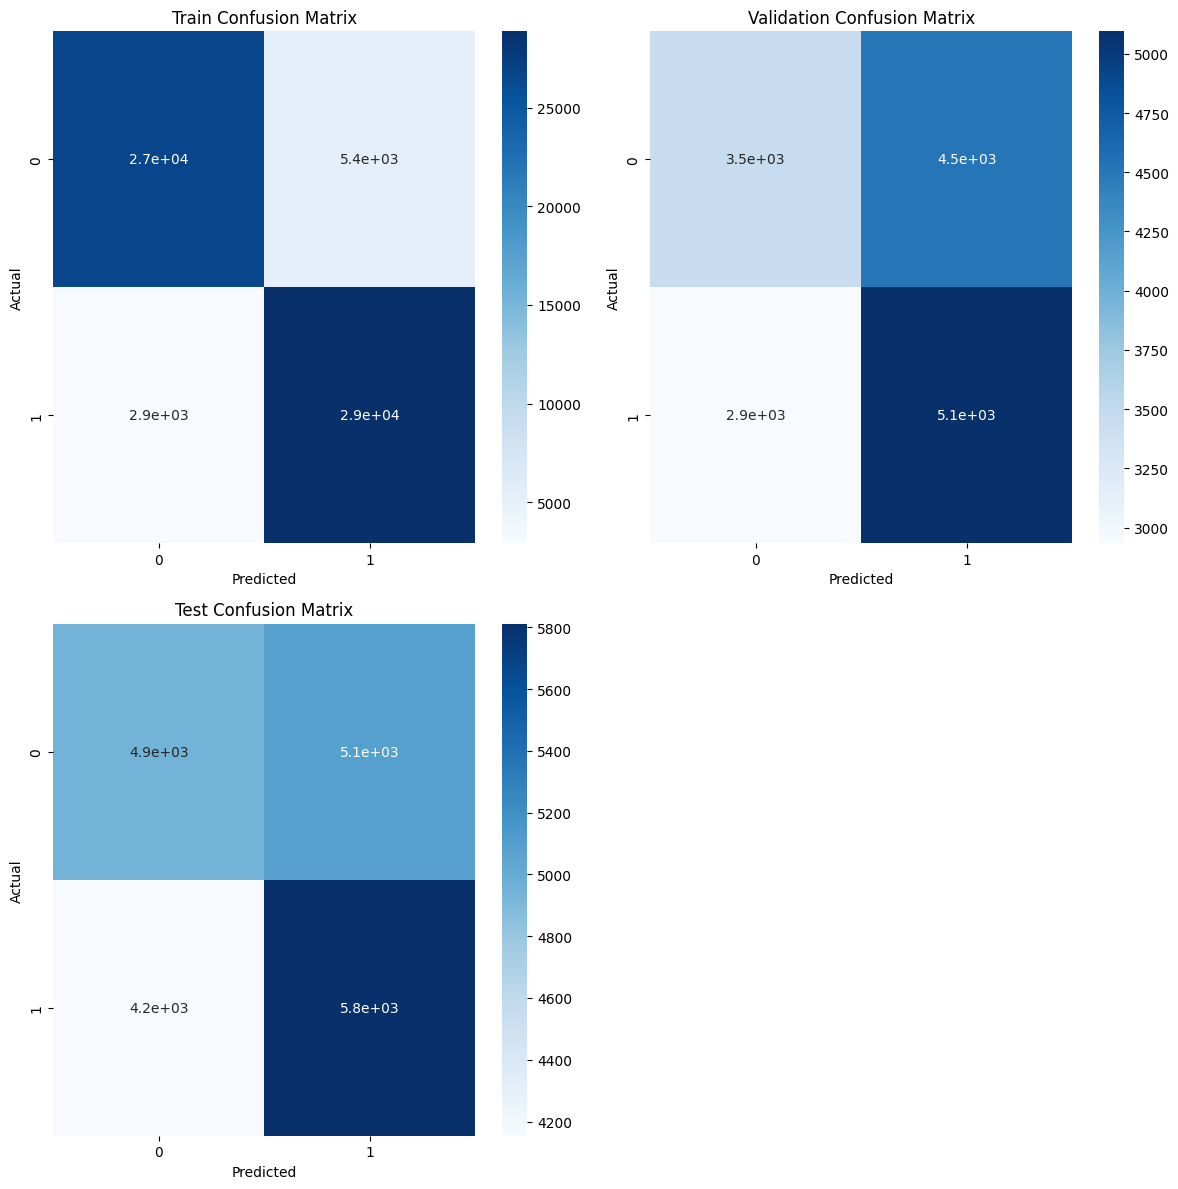

In [21]:
acc_train = accuracy_score(y_tr, y_tr_pred)
acc_valid = accuracy_score(y_va, y_va_pred)
acc_test = accuracy_score(y_te, y_te_pred)

print(f'Train accuracy: {acc_train}')
print(f'Validation accuracy: {acc_valid}\n')
print(f'Test accuracy: {acc_test}\n')

cm_train = confusion_matrix(y_tr, y_tr_pred)
cm_valid = confusion_matrix(y_va, y_va_pred)
cm_test = confusion_matrix(y_te, y_te_pred)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.heatmap(cm_train, annot=True, cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,2)
sns.heatmap(cm_valid, annot=True, cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,3)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(x_tr_bow, y_tr)

RandomForestClassifier()

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

y_tr_pred = rfc.predict(x_tr_bow)
y_va_pred = rfc.predict(x_va_bow)
y_te_pred = rfc.predict(x_te_bow)

Train accuracy: 0.964546875
Validation accuracy: 0.5375625

Test accuracy: 0.52745



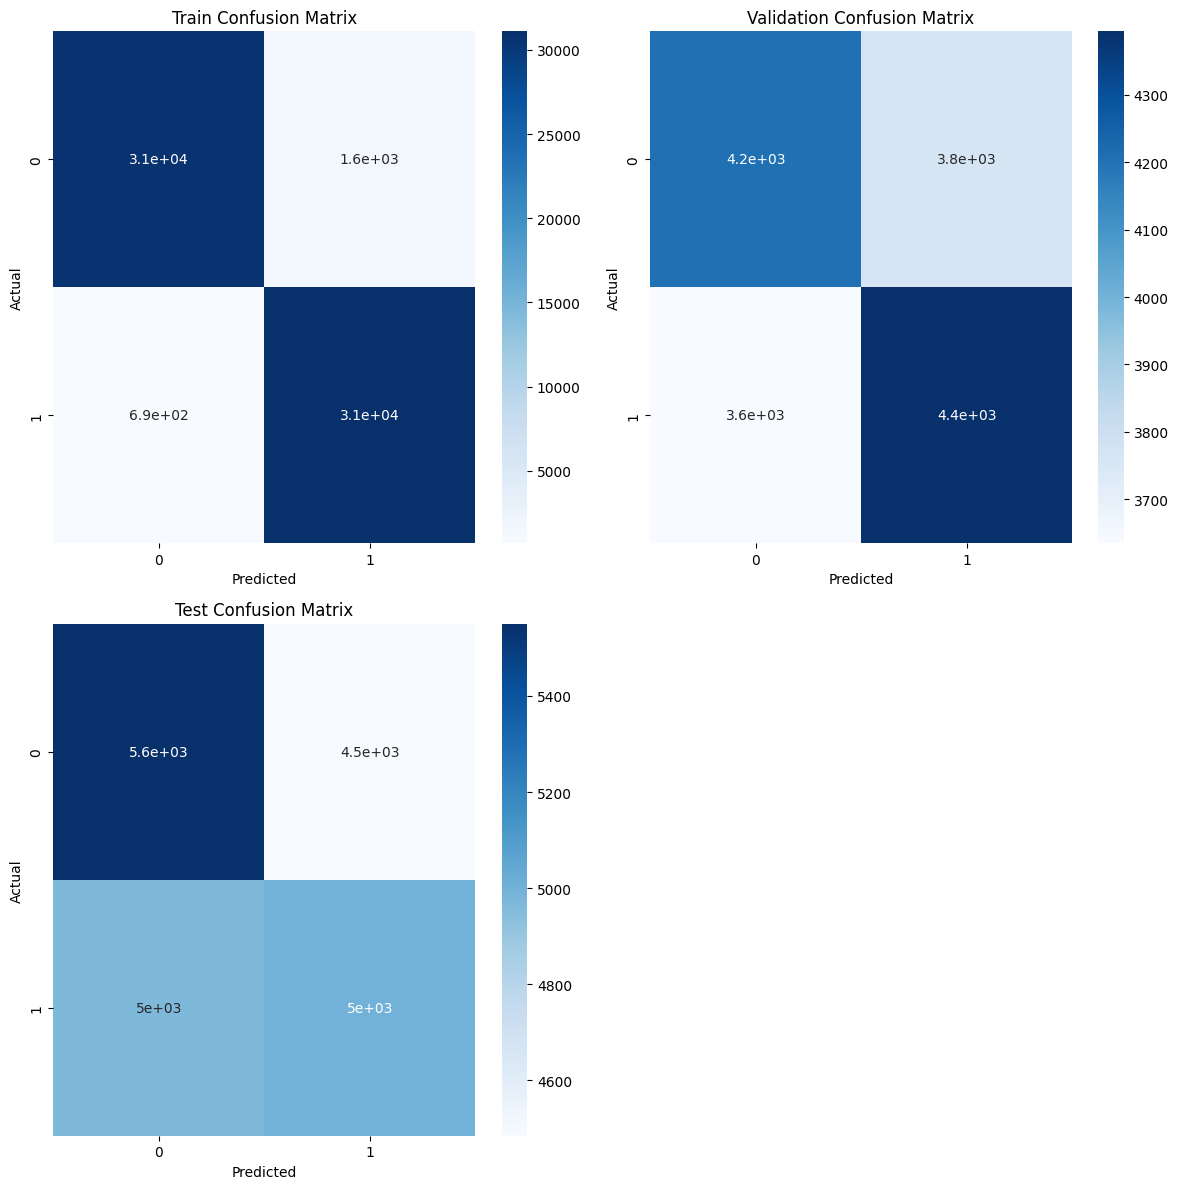

In [26]:
acc_train = accuracy_score(y_tr, y_tr_pred)
acc_valid = accuracy_score(y_va, y_va_pred)
acc_test = accuracy_score(y_te, y_te_pred)

print(f'Train accuracy: {acc_train}')
print(f'Validation accuracy: {acc_valid}\n')
print(f'Test accuracy: {acc_test}\n')

cm_train = confusion_matrix(y_tr, y_tr_pred)
cm_valid = confusion_matrix(y_va, y_va_pred)
cm_test = confusion_matrix(y_te, y_te_pred)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.heatmap(cm_train, annot=True, cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,2)
sns.heatmap(cm_valid, annot=True, cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,3)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

## TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

corpus_tf = vectorizer.fit_transform(corpus)

x_tr_tf, x_te_tf, y_tr, y_te = train_test_split(corpus_tf, labels, test_size=0.2, random_state=42)
x_tr_tf, x_va_tf, y_tr, y_va = train_test_split(x_tr_tf, y_tr, test_size=0.2, random_state=42)

x_tr_tf.shape, x_va_tf.shape, x_te_tf.shape

((64000, 63604), (16000, 63604), (20000, 63604))

### SVM

In [18]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(x_tr_tf, y_tr)

SVC(random_state=42)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

y_tr_pred = svc.predict(x_tr_tf)
y_va_pred = svc.predict(x_va_tf)
y_te_pred = svc.predict(x_te_tf)

Train accuracy: 0.95371875
Validation accuracy: 0.7726875

Test accuracy: 0.77105



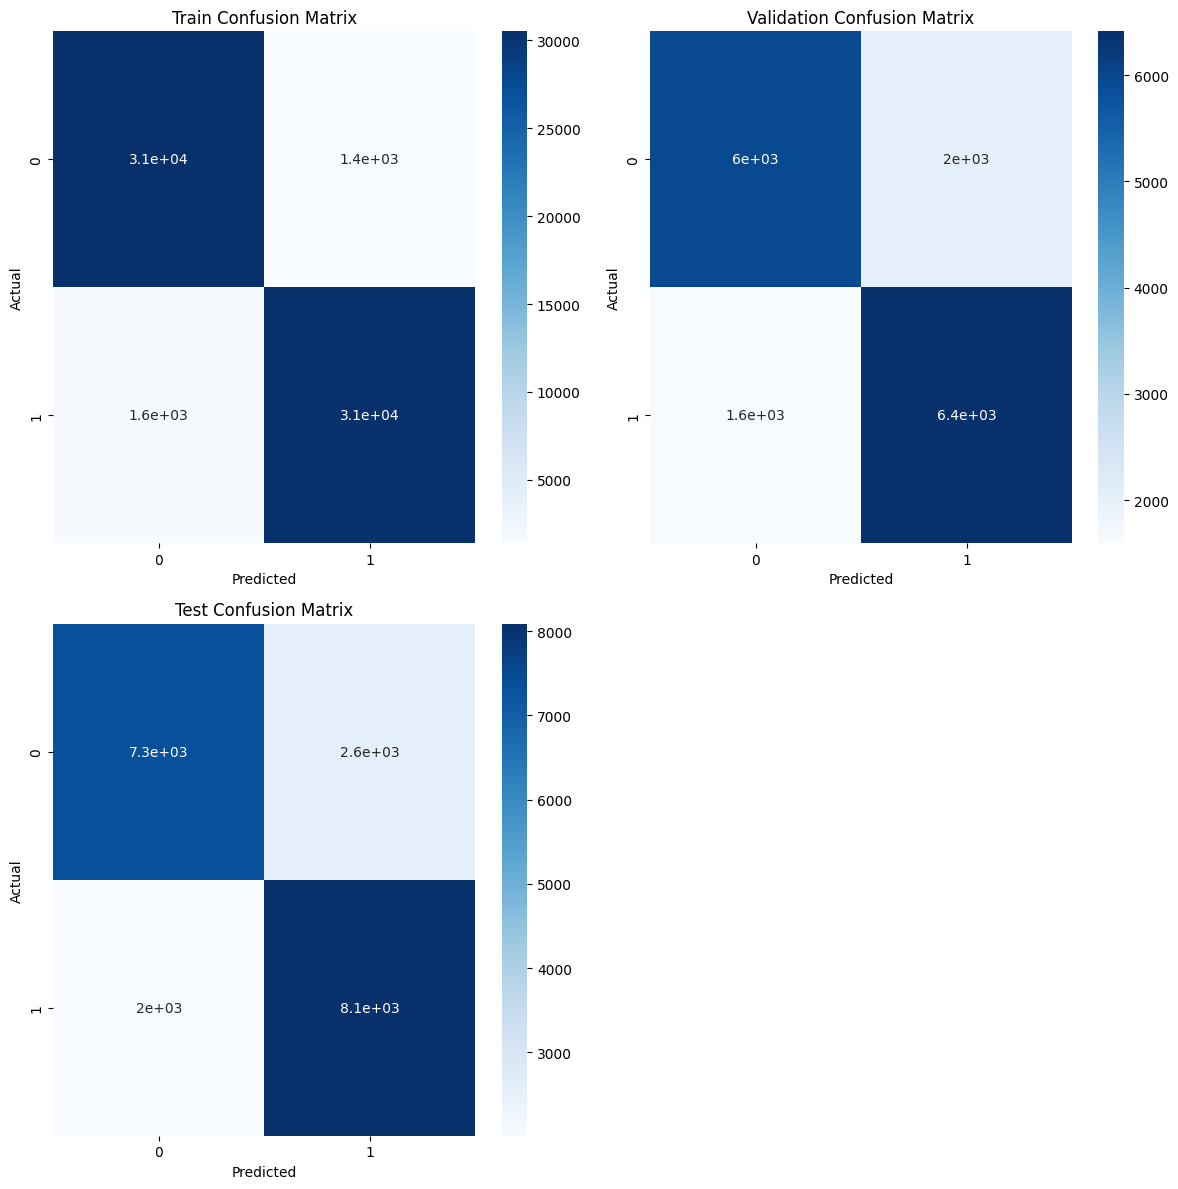

In [20]:
acc_train = accuracy_score(y_tr, y_tr_pred)
acc_valid = accuracy_score(y_va, y_va_pred)
acc_test = accuracy_score(y_te, y_te_pred)

print(f'Train accuracy: {acc_train}')
print(f'Validation accuracy: {acc_valid}\n')
print(f'Test accuracy: {acc_test}\n')

cm_train = confusion_matrix(y_tr, y_tr_pred)
cm_valid = confusion_matrix(y_va, y_va_pred)
cm_test = confusion_matrix(y_te, y_te_pred)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.heatmap(cm_train, annot=True, cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,2)
sns.heatmap(cm_valid, annot=True, cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,3)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(x_tr_tf, y_tr)

RandomForestClassifier()

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

y_tr_pred = rfc.predict(x_tr_tf)
y_va_pred = rfc.predict(x_va_tf)
y_te_pred = rfc.predict(x_te_tf)

Train accuracy: 0.995375
Validation accuracy: 0.7519375

Test accuracy: 0.7559



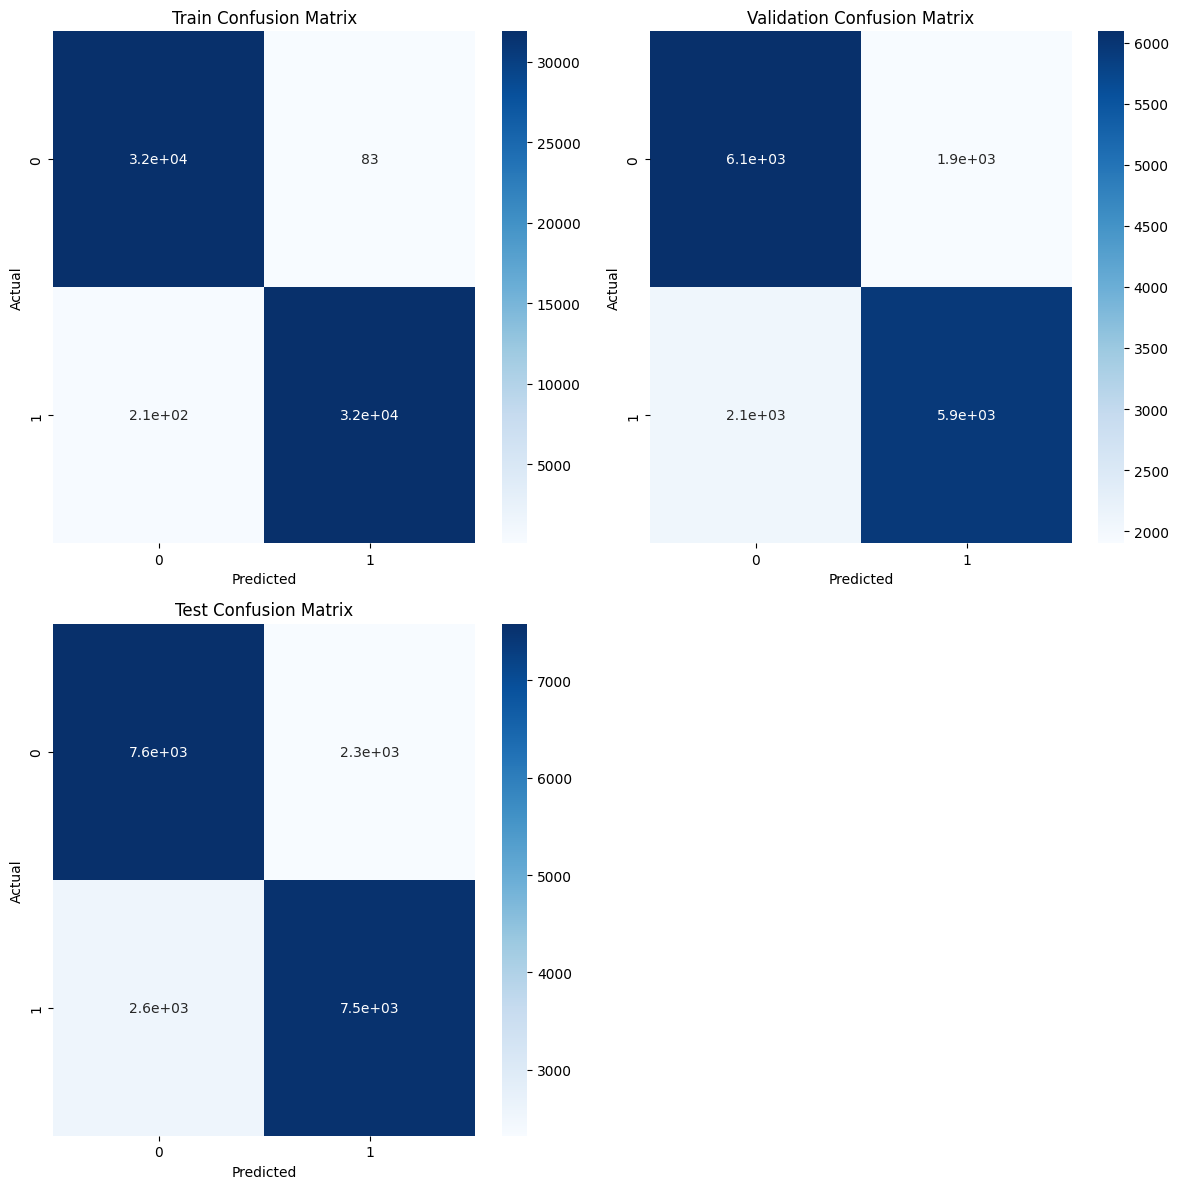

In [23]:
acc_train = accuracy_score(y_tr, y_tr_pred)
acc_valid = accuracy_score(y_va, y_va_pred)
acc_test = accuracy_score(y_te, y_te_pred)

print(f'Train accuracy: {acc_train}')
print(f'Validation accuracy: {acc_valid}\n')
print(f'Test accuracy: {acc_test}\n')

cm_train = confusion_matrix(y_tr, y_tr_pred)
cm_valid = confusion_matrix(y_va, y_va_pred)
cm_test = confusion_matrix(y_te, y_te_pred)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.heatmap(cm_train, annot=True, cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,2)
sns.heatmap(cm_valid, annot=True, cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2,2,3)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

# BERT

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('filtered_df.csv', encoding='latin-1')
df.dropna()
df = df[df['tweet_filtered'].apply(lambda x: isinstance(x, str))]

df_new = df.sample(n=100000)

corpus = df_new['tweet_filtered']
labels = df_new['label']

x_tr, x_te, y_tr, y_te = train_test_split(corpus, labels, test_size=0.2, random_state=42)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

In [4]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model = model.to(device)

training_args = TrainingArguments(
    output_dir='./BERT_results',          
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,             
    logging_dir='./BERT_logs',           
)

train_encodings = tokenizer(x_tr.tolist(), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(x_va.tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(x_te.tolist(), truncation=True, padding=True, return_tensors='pt')

y_tr_ten = torch.tensor(np.where(y_tr == 0, 0, 1)).long()
y_va_ten = torch.tensor(np.where(y_va == 0, 0, 1)).long()
y_te_ten = torch.tensor(np.where(y_te == 0, 0, 1)).long()

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_tr_ten)
val_dataset = CustomDataset(val_encodings, y_va_ten)
test_dataset = CustomDataset(test_encodings, y_te_ten)

trainer = Trainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset          
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
trainer.train()

Step,Training Loss
500,0.588200
1000,0.512100
1500,0.496500
2000,0.490500
2500,0.485300
3000,0.481500
3500,0.464300
4000,0.474600
4500,0.375200
5000,0.393200


TrainOutput(global_step=20000, training_loss=0.29066364002227785, metrics={'train_runtime': 2893.4828, 'train_samples_per_second': 110.593, 'train_steps_per_second': 6.912, 'total_flos': 1.08533310336e+16, 'train_loss': 0.29066364002227785, 'epoch': 5.0})

In [6]:
from sklearn.metrics import accuracy_score

train_predictions = trainer.predict(train_dataset)
val_predictions = trainer.predict(val_dataset)
test_predictions = trainer.predict(test_dataset)

train_preds = np.argmax(train_predictions.predictions, axis=1)
val_preds = np.argmax(val_predictions.predictions, axis=1)
test_preds = np.argmax(test_predictions.predictions, axis=1)

train_acc = accuracy_score(y_tr_ten, train_preds)
val_acc = accuracy_score(y_va_ten, val_preds)
test_acc = accuracy_score(y_te_ten, test_preds)

print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.98784375
Validation Accuracy: 0.7841875
Test Accuracy: 0.78055


# DISTILBERT from Hugging Face

In [6]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('filtered_df.csv', encoding='latin-1')
df.dropna()
df = df[df['tweet_filtered'].apply(lambda x: isinstance(x, str))]

df_new = df.sample(n=100000)

corpus = df_new['tweet_filtered']
labels = df_new['label']

x_tr, x_te, y_tr, y_te = train_test_split(corpus, labels, test_size=0.2, random_state=42)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

In [18]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = model.to(device)

training_args = TrainingArguments(
    output_dir='./DISTIL_BERT_results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,             
    logging_dir='./DISTIL_BERT_logs',           
)

train_encodings = tokenizer(x_tr.tolist(), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(x_va.tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(x_te.tolist(), truncation=True, padding=True, return_tensors='pt')

y_tr_ten = torch.tensor(np.where(y_tr == 0, 0, 1)).long()
y_va_ten = torch.tensor(np.where(y_va == 0, 0, 1)).long()
y_te_ten = torch.tensor(np.where(y_te == 0, 0, 1)).long()

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_tr_ten)
val_dataset = CustomDataset(val_encodings, y_va_ten)
test_dataset = CustomDataset(test_encodings, y_te_ten)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

trainer = Trainer(
    model=model,                        
    args=training_args,                 
    train_dataset=train_dataset,        
    eval_dataset=val_dataset          
)

In [19]:
trainer.train()

Step,Training Loss
500,0.636300
1000,0.507600
1500,0.479000
2000,0.480600
2500,0.476200
3000,0.469000
3500,0.468600
4000,0.475200
4500,0.365400
5000,0.357400


TrainOutput(global_step=12000, training_loss=0.3600935916900635, metrics={'train_runtime': 781.7807, 'train_samples_per_second': 245.593, 'train_steps_per_second': 15.35, 'total_flos': 2434088450304000.0, 'train_loss': 0.3600935916900635, 'epoch': 3.0})

In [20]:
from sklearn.metrics import accuracy_score

train_predictions = trainer.predict(train_dataset)
val_predictions = trainer.predict(val_dataset)
test_predictions = trainer.predict(test_dataset)

train_preds = np.argmax(train_predictions.predictions, axis=1)
val_preds = np.argmax(val_predictions.predictions, axis=1)
test_preds = np.argmax(test_predictions.predictions, axis=1)

train_acc = accuracy_score(y_tr_ten, train_preds)
val_acc = accuracy_score(y_va_ten, val_preds)
test_acc = accuracy_score(y_te_ten, test_preds)

print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.963953125
Validation Accuracy: 0.786125
Test Accuracy: 0.78655


# Discussion and Report

## Cleaning 

We have defined a function for cleaning the comments. We seperate the hashtag words, lowercase the letters, remove all non-english words along with some other preprocessings.

A corpus is created based on this cleaning function on all of the collected tweets

## Bag Of Words

 **Train-Test Split** has divided the corpus in three parts. We have then tokenized the words using bag of words (sklearn **countvectorizer**) with 1000 maximum features.

We have then trained both a **SVM** and a **Random Forest** model on the training data. The accuracies along with confusion matrices of these models are determined for all three datasets. You may observe the results in the corresponding sections in the code 

## TF-IDF

There overall approach is the same. Only this time, the corpus can not be split in three datasets or else TF-IDF features of train and test matrices will be different which is not ideal. 

So, first TF-IDF has been applied on the corpus and then it's splitted into train, test, and validation.

We have then trained both a **SVM** and a **Random Forest** model on the training data. The accuracies along with confusion matrices of these models are determined for all three datasets. You may observe the results in the corresponding sections in the code. 

It is readily observed that TF-IDF yields better results. This is because we have limited the maximim features of Bag of Words to 1000 while TF-IDF calculates lots of more features.

## BERT

We have imported a pre-trained **BERT** model. We have tuned the model on our dataset using 5 epochs of training. The resulting matrices and configurations file for the **tuned BERT** model are saved but not uploaded to CW due to its large-file nature.

It is essential to say that BERT model has its own tokenizer and we haven't used neither TF-IDF nor BoW for this part.

This tuned model is then used to predict the labels on all three datasets. You can observe that the accuracy is much higher and has reached 80%. 

## DistilBERT from Hugging Face

Much like the BERT model in the previous section, we have imported the per-trained **DistilBERT** model and trained it on our dataset for 3 epochs. The resulting matrices and configurations file for the **tuned DistilBERT** model are saved but not uploaded to CW due to its large-file nature.

It is essential to say that DistilBERT model has its own tokenizer and we haven't used neither TF-IDF nor BoW for this part.

This tuned model is then used to predict the labels on all three datasets. You can observe that the accuracy is much higher and has reached 80%.

## Final Comments

I believe DistilBERT is a better classifier. It is created specifically for the task of sentiment analysis and has been trained using a rich dataset. We have observed that just tuning it with 3 epochs for a total time of 20 minutes has yielded the same classifcation accuracy as the BERT model with 5 epochs and 45 minutes of training time.

It can be argued that the labels from Random Forest and SVM classifiers are more interpretible because th feature extraction methods (**TF-IDF** and **BoW** are more precise and known for what they are worth for). Ignoring this one statement, makes the BERT and DistilBERT models the winners of our sentiment analysis challenge because of their better performance in terms of validation and test accuracy.